In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat May 15 18:13:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from skimage.feature import hog

import os
import pylab
from scipy import ndimage, misc
import cv2
import pickle

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
dataset_path1 = "/content/drive/MyDrive/Ai/Dataset/"
test_path = "/content/drive/MyDrive/Ai/Testset/"
model_path = "/content/drive/MyDrive/Ai/ModelDeep/R5/"
labels_dict = {'Glaucoma':0, 'Normal':1, 'Others':2}
number = 120

In [ ]:
import cv2 as cv
import numpy as ppool
def normallize(img):
  norm = ppool.zeros((800,800))
  final = cv.normalize(img,  norm, 0, 255, cv.NORM_MINMAX)
  return final

In [ ]:
def clahe(img_in):
  lab = cv2.cvtColor(img_in,cv2.COLOR_RGB2LAB)
  L, A, B = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
  L2 = clahe.apply(L)
  lab = cv2.merge((L2,A,B))
  im_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
  return im_clahe


In [ ]:
def get_test():
  test = []
  test_label = []
  tagname_file = os.listdir(test_path)
  for j,tagname in enumerate(tagname_file):
    image_file = os.listdir(test_path +tagname + '/')
    for j,img in enumerate(image_file):
      im = cv2.imread(test_path + tagname + '/' + img)
      im_rgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
      im_rgb = np.array(im_rgb)

      # Feature
      im_nor = normallize(im_rgb)
      im_clahe = clahe(im_nor)
      test.append(im_clahe)
      test_label.append(labels_dict[tagname])
  test,test_label = shuffle(test,test_label)
  return test, test_label

In [ ]:
def split_train_val(tagname, i):
  dataset_glaucoma = os.listdir(dataset_path1 + tagname)
  val_index = 4-i
  train = []
  train_label = []
  val = []
  val_label = []
  print(tagname)
  for k in range(0,5):
    if k == val_index :
      image_file = os.listdir(dataset_path1 + tagname + '/' + str(k))
      print(image_file)
      for j,img in enumerate(image_file):
        if j < number :
          im = cv2.imread(dataset_path1 + tagname + '/' + str(k) + '/' + img)
          im_rgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
          im_rgb = np.array(im_rgb)
          
          # Feature
          im_nor = normallize(im_rgb)
          im_clahe = clahe(im_nor)
          val.append(im_clahe)
          val_label.append(labels_dict[tagname])
    else:
      image_file = os.listdir(dataset_path1 + tagname + '/' + str(k))
      print(image_file)
      for j,img in enumerate(image_file):
        if j < number :
          im = cv2.imread(dataset_path1 + tagname + '/' + str(k) + '/' + img)
          im_rgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
          im_rgb = np.array(im_rgb)

          # Feature
          im_nor = normallize(im_rgb)
          im_clahe = clahe(im_nor)
          train.append(im_clahe)
          train_label.append(labels_dict[tagname])

  return train, train_label, val, val_label

In [ ]:
def shuffle(data, label):
  new_data = []
  new_label = []
  index = [i for i in range(len(data))]
  np.random.shuffle(index)
  for i in range(len(data)):



    new_data.append(data[index[i]])
    new_label.append(label[index[i]])
    

  new_data = np.array(new_data)
  new_label = np.array(new_label)
  n_classes = 3
  new_label = keras.utils.to_categorical(new_label, n_classes)

  return new_data, new_label
  


In [ ]:
def sum_data(k):
  file_name = os.listdir(dataset_path1)
  train = []
  train_label = []
  val = []
  val_label = []
  for name in file_name:
    print(name)
    train_name, train_name_label, val_name, val_name_label = split_train_val(name, k)
    train.extend(train_name)
    train_label.extend(train_name_label)
    val.extend(val_name)
    val_label.extend(val_name_label)
  return train, train_label, val, val_label

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
def confusion(y_test,pred) :
    label_name = ['Gluacoma', 'Normal', 'Others']
    #Confusion Matrix
    %matplotlib inline 

    confusion_mat1 = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
    print(confusion_mat1)
    sns.heatmap(confusion_mat1,annot=True,linewidths=1, fmt = 'd')


    plt.show()
    return confusion_mat1


In [ ]:
def extract_features(image):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    hog_image = hog_image.mean(axis=0)

    return hog_image

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import keras

def vgg_model(X_train_recv, y_train_recv, X_val_recv, y_val_recv, r) :


    INIT_LR = 1e-3 # 1e-3 -- 1e-4
    EPOCHS = 15
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    vgg_model = VGG16(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg_model.layers:
        layer.trainable = False
    
    new_model = vgg_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(128, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(3, activation="softmax")(new_model)
    model = Model(inputs=vgg_model.input, outputs=new_model)

    model.compile(
        # optimizer='adam', 
                  optimizer = opt,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

    #train Model 
    print("Wait for Trainning")
    
    history = model.fit(
        X_train_recv, # input
        y_train_recv, # output
        batch_size=32,
        verbose=1, 
        epochs=EPOCHS,
        validation_data=(X_val_recv, y_val_recv),
    ) 

    filename = 'model_'+ str(r) +'.h5'
    model.save('/content/drive/MyDrive/Ai/ModelDeep/R5/' +filename)
    print("Already Saved Model")

    y_pred = model.predict(X_val_recv)


    %matplotlib inline 
    print("Confusion matrix")
    confusion(y_val_recv,y_pred)
  
    fpr_sav = []
    tpr_sav = []
    acc_sav = []
    for oyah in range(0,3) :

      fpr, tpr, thresholds = roc_curve(y_val_recv[:,oyah], y_pred[:,oyah])
      roc_auc = metrics.auc(fpr, tpr)
      fpr_sav.append(fpr)
      tpr_sav.append(tpr)
      acc_sav.append(roc_auc)

    return fpr_sav, tpr_sav, acc_sav

In [ ]:
def roc(fpr_recv,tpr_recv,acc_recv,num=5) :
#     stck_auc = []
    color = ["orange","green","blue","red","purple"]
    for i in range(num):
        # print(i)
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]

        
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
    plt.show()

In [ ]:
# import รูปภาพจาก dataset
fpr_all = []
tpr_all = []
acc_all = []
for i in range(0,5):
  # Round 1 use 4 to val
  # Round 2 use 3 to val
  # Round 3 use 2 to val
  # Round 4 use 1 to val
  # Round 5 use 0 to val
  train_data, train_label, val_data, val_label = sum_data(i) 
  print(len(train_data), len(train_label), len(val_data), len(val_label))
  train_data, train_label = shuffle(train_data,train_label)
  val_data, val_label = shuffle(val_data,val_label)
  print(len(train_data), len(train_label), len(val_data), len(val_label))
  print(train_data.shape, train_label.shape, val_data.shape, val_label.shape)
  ## Model
  # Roc curve ของ 3 classes
  fpr, tpr, acc = vgg_model(train_data, train_label, val_data, val_label, i)
  fpr_all.append(fpr)
  tpr_all.append(tpr)
  acc_all.append(acc)

fpr_all = np.array(fpr_all)
tpr_all = np.array(tpr_all)
acc_all = np.array(acc_all)
for u in range(3):
  print("Graph Class ", str(u))
  roc(fpr_all[:,u], tpr_all[:,u], acc_all[:,u])

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
# Python script for confusion matrix creation. 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
%matplotlib inline


(294, 224, 224, 3) (294, 3)
Score: 80.61224222183228
[[100  22   3]
 [ 30  69   0]
 [  2   0  68]]


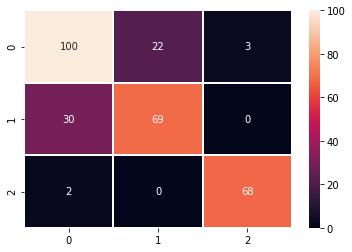

array([[100,  22,   3],
       [ 30,  69,   0],
       [  2,   0,  68]])

In [ ]:
# load the model from disk
filename = "/content/drive/MyDrive/Ai/ModelDeep/R5/model_1.h5"
X_test, Y_test = get_test()

print(X_test.shape, Y_test.shape)

INIT_LR = 1e-3 # 1e-3 -- 1e-4
EPOCHS = 15
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model_load = keras.models.load_model(filename)
model_load.compile(
    # optimizer='adam',
    optimizer = opt,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
pred_test = model_load.predict(X_test)
score = model_load.evaluate(X_test, Y_test, verbose=0)
print(f"Score: {score[1] * 100}")
confusion(Y_test, pred_test)



In [ ]:
print(f"Score: {score[1] * 100}")
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

[[100  22   3]
 [ 30  69   0]
 [  2   0  68]]


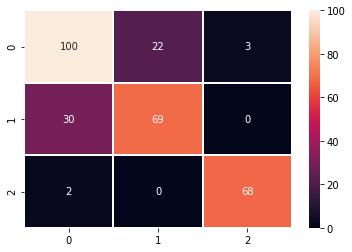

Confusion Matrix : 
 [[100  22   3]
 [ 30  69   0]
 [  2   0  68]]
Accuracy :  0.8061224489795918
Sensitivity Class 0:  0.7575757575757576
Specificity Class 0:  0.8106508875739645
Sensitivity Class 1:  0.7582417582417582
Specificity Class 1:  0.8871794871794871
Sensitivity Class 2:  0.9577464788732394
Specificity Class 2:  0.9910313901345291
Report : 
              precision    recall  f1-score   support

           0     0.7576    0.8000    0.7782       125
           1     0.7582    0.6970    0.7263        99
           2     0.9577    0.9714    0.9645        70

    accuracy                         0.8061       294
   macro avg     0.8245    0.8228    0.8230       294
weighted avg     0.8055    0.8061    0.8051       294



In [ ]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
%matplotlib inline
cm1 = confusion(Y_test,pred_test)

print('Confusion Matrix : \n', cm1)

total = sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm1[0,0]+cm1[1,1]+cm1[2,2])/total
print ('Accuracy : ', accuracy0)

sensitivity0 = cm1[0,0]/(cm1[0,0]+cm1[1,0]+cm1[2,0])
print('Sensitivity Class 0: ', sensitivity0 )

specificity0 = (cm1[1,1]+cm1[2,2]+cm1[1,2]+cm1[2,1])/(cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])
print('Specificity Class 0: ', specificity0)

sensitivity1 = cm1[1,1]/(cm1[1,1]+cm1[0,1]+cm1[2,1])
print('Sensitivity Class 1: ', sensitivity1)

specificity1 = (cm1[0,0]+cm1[0,2]+cm1[2,0]+cm1[2,2])/(cm1[0,0]+cm1[0,2]+cm1[2,0]+cm1[2,2]+cm1[0,1]+cm1[2,1])
print('Specificity Class 1: ', specificity1)

sensitivity2 = cm1[2,2]/(cm1[2,2]+cm1[0,2]+cm1[1,2])
print('Sensitivity Class 2: ', sensitivity2)

specificity2 = (cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1]+cm1[2,0]+cm1[2,1])
print('Specificity Class 2: ', specificity2)

print( 'Report : ')
print(classification_report(Y_test.argmax(axis=1), pred_test.argmax(axis=1),digits=4))